# Visualize

## Preparation

In [7]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import zipfile
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import seaborn as sns

In [2]:
z = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv(z.open('train.csv'))
import cPickle as pickle
with open('dropped_features.dump', 'r') as f:
    dropped_features = pickle.load(f)
df.drop(dropped_features, axis=1, inplace=True)

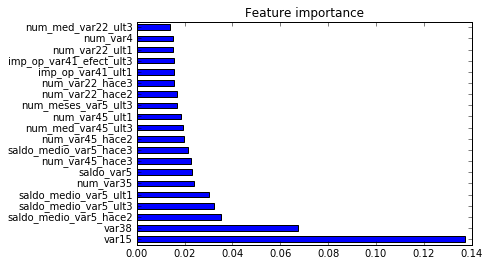

In [4]:
x = df.drop(['ID', 'TARGET'], axis=1)
y = df['TARGET']
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=16, oob_score=True)
rfc.fit(x, y)
feat_imp = pd.Series(rfc.feature_importances_, index=x.columns)
feat_imp.sort_values(inplace=True, ascending=False)
feat_imp.head(20).plot(kind='barh', title='Feature importance')

In [52]:
# 241 features (raw - constants/linear)
cv = cross_validation.StratifiedKFold(y, n_folds=4, shuffle=True)
scores = cross_validation.cross_val_score(rfc, x, y, cv=cv, scoring='roc_auc')
print("Auc: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

Auc: 0.821 (+/- 0.005)


In [5]:
def filter_feature_by_importance_percentage(imp, per):
    assert per <= 1.0 and per >= 0
    imp_sorted = imp.sort_values(ascending=False)
    total_per = 0
    for (i, v) in enumerate(imp_sorted):
            total_per += v
            if total_per >= per:
                return imp[:i+1]
    return imp

In [18]:
print len(feat_imp)
filtered_feat_imp = filter_feature_by_importance_percentage(feat_imp, 0.95)
filtered_feat_imp_list = list(filtered_feat_imp.index.values)
print len(filtered_feat_imp)

239
89


In [50]:
x = df[filtered_feat_imp.index.values]
y = df['TARGET']
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=16, oob_score=True)
cv = cross_validation.StratifiedKFold(y, n_folds=4, shuffle=True)
scores = cross_validation.cross_val_score(rfc, x, y, cv=cv, scoring='roc_auc')
print("Auc: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

Auc: 0.829 (+/- 0.010)


## Pairwise Feature Visualization

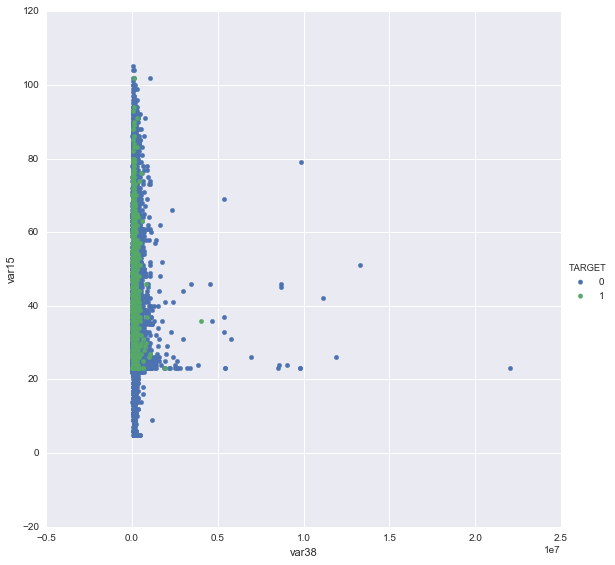

In [9]:
sns.FacetGrid(df, hue="TARGET", size=8).map(plt.scatter, "var38", "var15").add_legend()

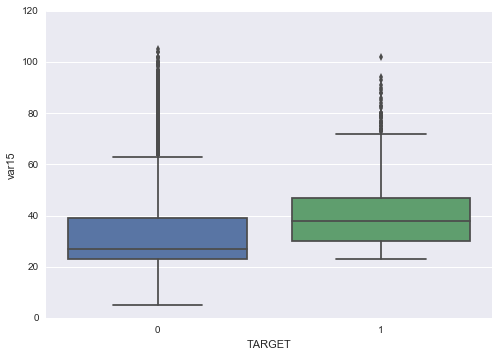

In [10]:
sns.boxplot(x='TARGET', y='var15', data=df)

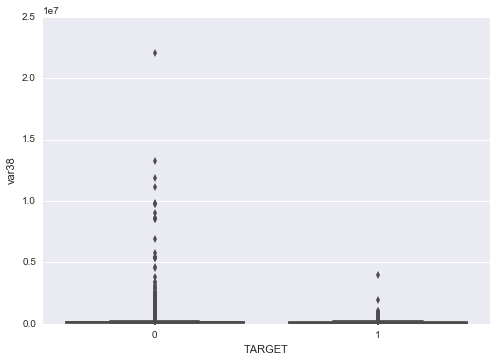

In [14]:
# How to scale this?
sns.boxplot(x='TARGET', y='var38', data=df)

In [20]:
def top_k_feature_pairwise_plot(df, imp, target):
    df = df[imp + [target]]
    sns.pairplot(data = df, hue=target, vars=imp, size=8)

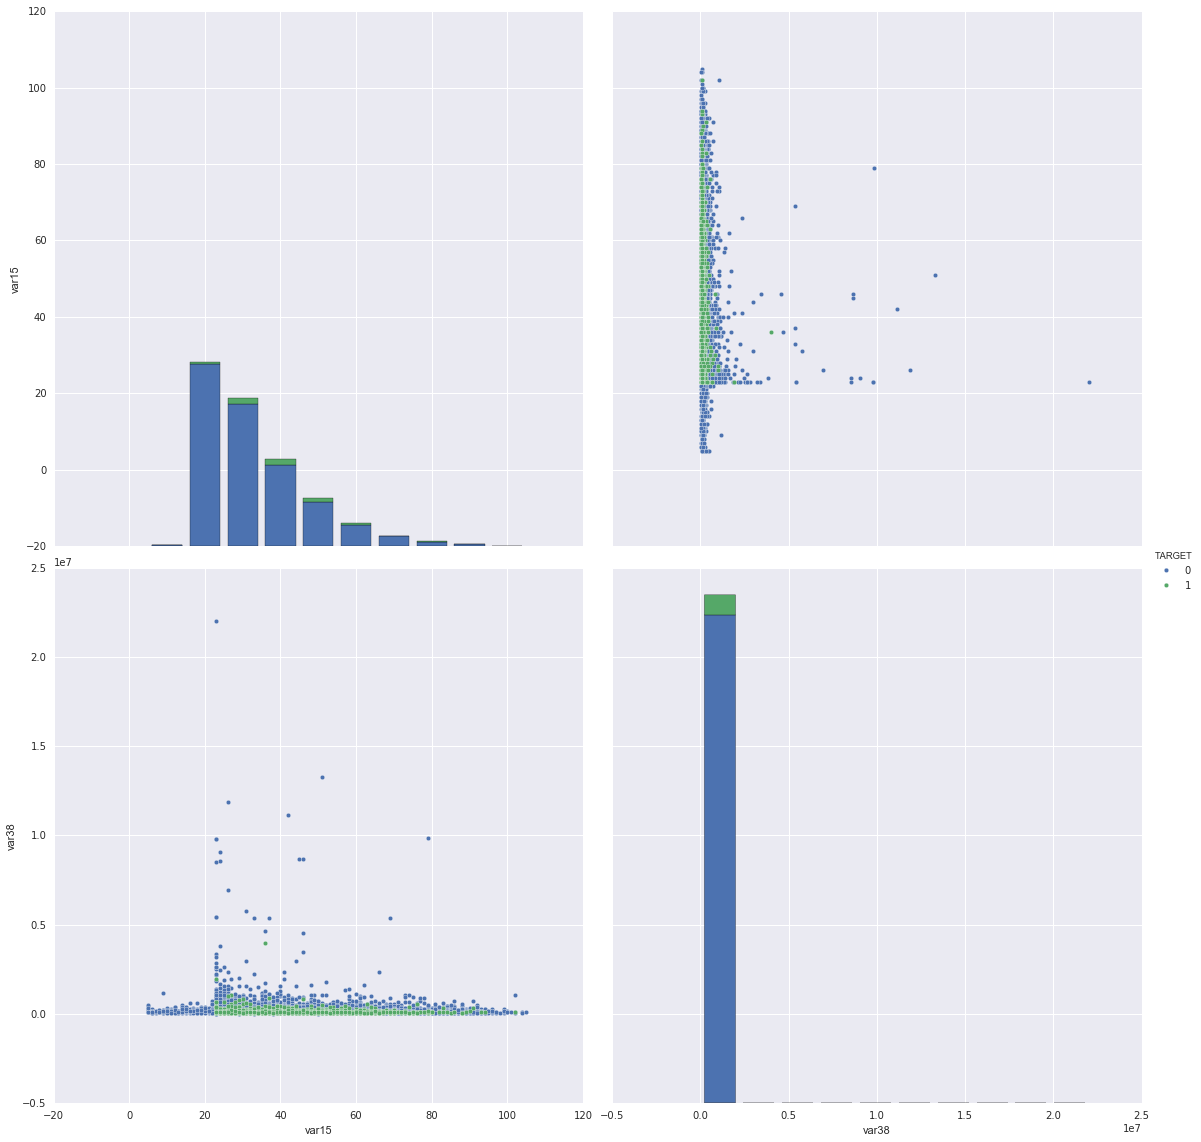

In [21]:
top_k_feature_pairwise_plot(df, filtered_feat_imp_list[:2], 'TARGET')